In [1]:
%matplotlib inline

4. Train SSD on Pascal VOC dataset
======================================

This tutorial goes through the basic building blocks of object detection
provided by GluonCV.
Specifically, we show how to build a state-of-the-art Single Shot Multibox
Detection [Liu16]_ model by stacking GluonCV components.
This is also a good starting point for your own object detection project.


Dataset
-------

Data Download:




In [2]:
from gluoncv.data import VOCDetection
# typically we use 2007+2012 trainval splits for training data
train_dataset = VOCDetection(splits=[(2007, 'trainval'), (2012, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(splits=[(2007, 'test')])

print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 16551
Validation images: 4952


In [3]:
!pip list | grep mxnet

keras-mxnet                        2.2.2         
mxnet-cu90                         1.5.0b20181212
mxnet-model-server                 0.4           
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Data transform
------------------
We can read an image-label pair from the training dataset:



In [4]:
train_image, train_label = train_dataset[0]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (375, 500, 3)
bboxes: (5, 4) class ids: (5, 1)


Plot the image, together with the bounding box labels:



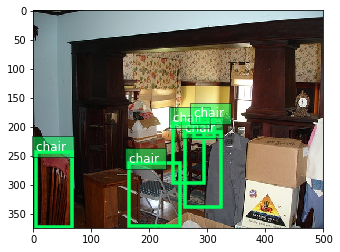

In [5]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(
    train_image.asnumpy(),
    bboxes,
    labels=cids,
    class_names=train_dataset.classes)
plt.show()

Validation images are quite similar to training because they were
basically split randomly to different sets



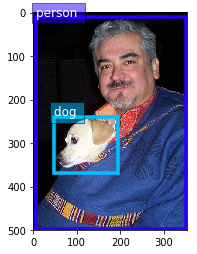

In [6]:
val_image, val_label = val_dataset[0]
bboxes = val_label[:, :4]
cids = val_label[:, 4:5]
ax = viz.plot_bbox(
    val_image.asnumpy(),
    bboxes,
    labels=cids,
    class_names=train_dataset.classes)
plt.show()

For SSD networks, it is critical to apply data augmentation (see explanations in paper [Liu16]_).
We provide tons of image and bounding box transform functions to do that.
They are very convenient to use as well.



In [7]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [8]:
width, height = 512, 512  # suppose we use 512 as base training size
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height)
val_transform = presets.ssd.SSDDefaultValTransform(width, height)

In [9]:
utils.random.seed(233)  # fix seed in this tutorial

apply transforms to train image



In [10]:
train_image2, train_label2 = train_transform(train_image, train_label)
print('tensor shape:', train_image2.shape)

tensor shape: (3, 512, 512)


Images in tensor are distorted because they no longer sit in (0, 255) range.
Let's convert them back so we can see them clearly.



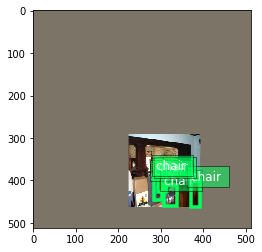

In [11]:
train_image2 = train_image2.transpose(
    (1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(train_image2.asnumpy(), train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

apply transforms to validation image



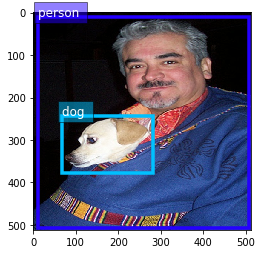

In [12]:
val_image2, val_label2 = val_transform(val_image, val_label)
val_image2 = val_image2.transpose(
    (1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image2 = (val_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(val_image2.clip(0, 255).asnumpy(), val_label2[:, :4],
                   labels=val_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

Transforms used in training include random expanding, random cropping, color distortion, random flipping, etc.
In comparison, validation transforms are simpler and only resizing and
color normalization is used.



Data Loader
------------------
We will iterate through the entire dataset many times during training.
Keep in mind that raw images have to be transformed to tensors
(mxnet uses BCHW format) before they are fed into neural networks.
In addition, to be able to run in mini-batches,
images must be resized to the same shape.

A handy DataLoader would be very convenient for us to apply different transforms and aggregate data into mini-batches.

Because the number of objects varys a lot across images, we also have
varying label sizes. As a result, we need to pad those labels to the same size.
To deal with this problem, GluonCV provides :py:class:`gluoncv.data.batchify.Pad`,
which handles padding automatically.
:py:class:`gluoncv.data.batchify.Stack` in addition, is used to stack NDArrays with consistent shapes.
:py:class:`gluoncv.data.batchify.Tuple` is used to handle different behaviors across multiple outputs from transform functions.



In [13]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 32  # for tutorial, we use smaller batch-size
# you can make it larger(if your CPU has more cores) to accelerate data loading
num_workers = 0

# behavior of batchify_fn: stack images, and pad labels
batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
train_loader = DataLoader(
    train_dataset.transform(train_transform),
    batch_size,
    shuffle=True,
    batchify_fn=batchify_fn,
    last_batch='rollover',
    num_workers=num_workers)
val_loader = DataLoader(
    val_dataset.transform(val_transform),
    batch_size,
    shuffle=False,
    batchify_fn=batchify_fn,
    last_batch='keep',
    num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data:', batch[0].shape, 'label:', batch[1].shape)

data: (32, 3, 512, 512) label: (32, 17, 6)
data: (32, 3, 512, 512) label: (32, 15, 6)
data: (32, 3, 512, 512) label: (32, 6, 6)
data: (32, 3, 512, 512) label: (32, 9, 6)


SSD Network
------------------
GluonCV's SSD implementation is a composite Gluon HybridBlock
(which means it can be exported
to symbol to run in C++, Scala and other language bindings.
We will cover this usage in future tutorials).
In terms of structure, SSD networks are composed of base feature extraction
network, anchor generators, class predictors and bounding box offset predictors.

For more details on how SSD detector works, please refer to our introductory
[tutorial](http://gluon.mxnet.io/chapter08_computer-vision/object-detection.html)
You can also refer to the original paper to learn more about the intuitions
behind SSD.

The Gluon Model Zoo has a lot of built-in SSD networks.
You can load your favorate one with one simple line of code:


In [14]:
from gluoncv import model_zoo
net = model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained_base=False)
print(net)

SSD(
  (features): FeatureExpander(
  
  )
  (class_predictors): HybridSequential(
    (0): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (5): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (box_predictors): HybridSequential(
    (0): ConvPredictor(
      (predictor): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvPredictor(
      (predicto

SSD network is a HybridBlock as mentioned before. You can call it with
an input as:



In [15]:
import mxnet as mx
x = mx.nd.zeros(shape=(1, 3, 512, 512))
net.initialize()
cids, scores, bboxes = net(x)

SSD returns three values, where ``cids`` are the class labels,
``scores`` are confidence scores of each prediction,
and ``bboxes`` are absolute coordinates of corresponding bounding boxes.



SSD network behave differently during training mode:



In [16]:
from mxnet import autograd
with autograd.train_mode():
    cls_preds, box_preds, anchors = net(x)

In training mode, SSD returns three intermediate values,
where ``cls_preds`` are the class predictions prior to softmax,
``box_preds`` are bounding box offsets with one-to-one correspondence to anchors
and ``anchors`` are absolute coordinates of corresponding anchors boxes, which are
fixed since training images use inputs of same dimensions.



Training targets
------------------
Unlike a single ``SoftmaxCrossEntropyLoss`` used in image classification,
the loss used in SSD is more complicated.
Don't worry though, because we have these modules available out of the box.

To speed up training, we let CPU to pre-compute some training targets.
This is especially nice when your CPU is powerful and you can use ``-j num_workers``
to utilize multi-core CPU.



In [17]:
num_workers=4

If we provide anchors to the training transform, it will compute
training targets



In [18]:
from mxnet import gluon
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
batchify_fn = Tuple(Stack(), Stack(), Stack())
train_loader = DataLoader(
    train_dataset.transform(train_transform),
    batch_size,
    shuffle=True,
    batchify_fn=batchify_fn,
    last_batch='rollover',
    num_workers=num_workers)

Loss, Trainer and Training pipeline



In [19]:
from gluoncv.loss import SSDMultiBoxLoss
mbox_loss = SSDMultiBoxLoss()

In [20]:
epochs = 2
ctx = mx.gpu(0)
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.01, 'wd': 0.0005, 'momentum': 0.9})

In [21]:
import time

In [22]:
for e in range(epochs):
    loss = 0.
    tic = time.time()
    for i, (data, cls_targets, box_targets) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        cls_targets = cls_targets.as_in_context(ctx)
        box_targets = box_targets.as_in_context(ctx)
        with autograd.record():
            cls_pred, box_pred, anchors = net(data)
            sum_loss, cls_loss, box_loss = mbox_loss(cls_pred, box_pred, cls_targets, box_targets)
            loss += sum(sum_loss).mean().asscalar()
        autograd.backward(sum_loss)
        trainer.step(1)
        if i % 20 == 0 and i > 0:
            print("[{}] Running loss: {}, Samples/sec {}".format(i, loss/(i+1), data.shape[0]*50/(time.time()-tic)))
            tic = time.time()

[20] Running loss: 0.5551290512084961, Samples/sec 21.838160009602053
[40] Running loss: 0.4690924701167316, Samples/sec 41.110177858406246
[60] Running loss: 0.42627767900951574, Samples/sec 38.51204654367785
[80] Running loss: 0.400947023689011, Samples/sec 36.86321217933688
[100] Running loss: 0.3827813964078922, Samples/sec 37.96932859155475
[120] Running loss: 0.3705343860240022, Samples/sec 37.883384320964126
[140] Running loss: 0.3603294643949955, Samples/sec 40.46289832790618
[160] Running loss: 0.35203975550136213, Samples/sec 39.65682432549062
[180] Running loss: 0.3461955909241629, Samples/sec 39.37671247738588
[200] Running loss: 0.3404063646176561, Samples/sec 37.60024021979262
[220] Running loss: 0.3357013581295359, Samples/sec 39.38396820590106
[240] Running loss: 0.3312983985263777, Samples/sec 38.24209199443385
[260] Running loss: 0.32700762095579244, Samples/sec 41.4042181845876
[280] Running loss: 0.3232225499967663, Samples/sec 40.556103145071766
[300] Running loss:

This time we can see the data loader is actually returning the training targets for us.
Then it is very naturally a gluon training loop with Trainer and let it update the weights.


Testing our model
-------------------------

Let's get our trained SSD model trained with 512x512 images on Pascal VOC
dataset with ResNet-50 V1 as the base model. 

In [32]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/street_small.jpg?raw=true',
                          path='street_small.jpg')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=800)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 800, 800)


In [ ]:
pred = net(x.as_in_context(ctx))

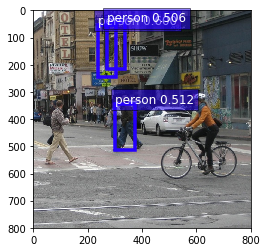

In [36]:
class_IDs, scores, bounding_boxs = pred

ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0]*3,
                         class_IDs[0], class_names=net.classes)
plt.show()

References
----------

.. [Liu16] Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg. SSD: Single Shot MultiBox Detector. ECCV 2016.

